# Permutation Feature-based Frequency Response Analysis
## A brief tutorial for PFFRA-v0.1.2

In [1]:
import PFFRA
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor

#### Generate synthetic data for regression

In [2]:
# Generate a simple synthetic dataset
t = np.linspace(0,10,1000)
x1 = np.sin(2 * np.pi * 10 * t)
x2 = np.sin(2 * np.pi * 37 * t)
x3 = np.cos(2* np.pi * 39 * t)

X = np.vstack((x1, x2, x3)).T
y = 5*x1+2*x2+3*x3

#### Train a XGBM model and generate predictions

In [3]:
model = XGBRegressor(n_estimators = 5)
model = model.fit(X, y)
y_hat = model.predict(X)

#### Plot predictions

Text(0.5, 1.0, 'XGBM predicted time series')

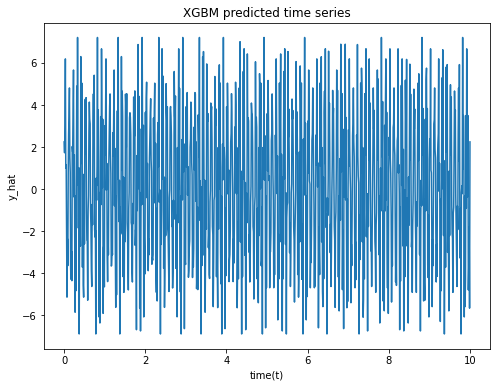

In [4]:
plt.figure(figsize = (8, 6))
plt.plot(t, y_hat)
plt.xlabel("time(t)")
plt.ylabel("y_hat")
plt.title("XGBM predicted time series")

#### Apply PFFRA
##### Draw spectrum figures directly for a given interested feature index
By instantiating class **PermFeatureFreqRespoAnalysis** to specify the feature index as 1, we are able to call **show()** to draw the graph that compares the spectrums with the feature $x_1$ and other features are permuted by thier mean values. The lower subfigure shows the frequency response using the original dataset with all features. 

In this example, we use **mean** value to permute the wanted feature.

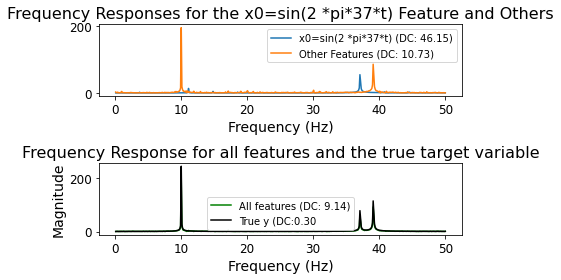

In [5]:
pffra = PFFRA.PermFeatureFreqRespoAnalysis(y = y, X = X, model = model, 
                                           interested_feature_index = 1)
pffra.show(sample_rate = 100, mode = 'mean', rename_feature = "x0=sin(2 *pi*37*t)")

##### Investigate multiple features and output their permutation spectrum data
Calling **gen_spectrum()** method allows us to get access to the spectrum data for any feature.

In this example, we shuffle the values for the wanted feature for the permutation purpose.

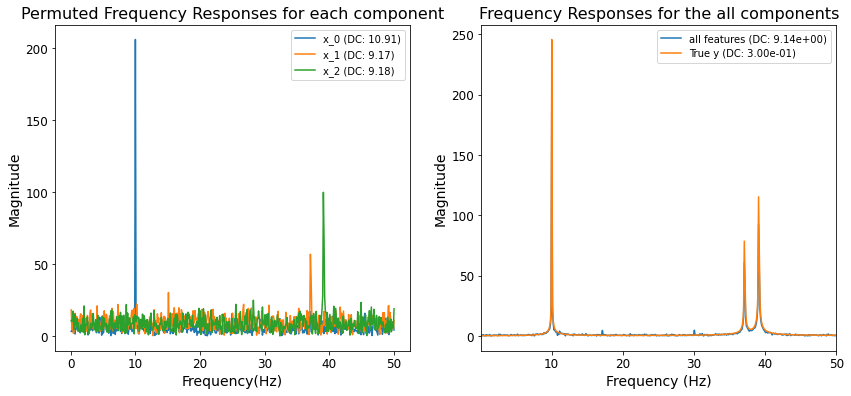

In [6]:
fig = plt.figure(figsize = (14,6))
ax1 = fig.add_subplot(121)
for i in range(X.shape[1]):
    # instantiate PFFRA
    pffra = PFFRA.PermFeatureFreqRespoAnalysis(y = y, X = X, model = model, interested_feature_index = i)
    # Generate permutation dataset
    X_interested_feature, X_other_feature = pffra.permuted_dataset(mode = 'shuffle')
    # Predict target variables using the permutated datasets
    pred_interested_feature, pred_other_feature, pred_all_feature = pffra.permu_pred(X_interested_feature, X_other_feature)
    # Generate spectrums for analysis
    spectrums = pffra.gen_spectrum(pred_interested_feature = pred_interested_feature, 
                                   pred_other_feature = pred_other_feature, 
                                   pred_all_feature = pred_all_feature, 
                                   sample_rate = 100)
    # Unpack spectrums
    spectrum_interested_i = spectrums[0]
    spectrum_all = spectrums[2]
    spectrum_true = spectrums[3]
    frq_range = spectrums[4]
    
    plt.rcParams["axes.labelsize"] = 14
    plt.rcParams["axes.titlesize"] = 16  
    plt.rcParams["xtick.labelsize"] = "large"
    plt.rcParams["ytick.labelsize"] = "large"
    ax1.plot(frq_range[1:], spectrum_interested_i[1:], 
             label = "x_{} (DC: {:.2f})".format(i, spectrum_interested_i[0]))
    ax1.legend()
    ax1.set_xlabel("Frequency(Hz)")
    ax1.set_ylabel("Magnitude")
    ax1.set_title("Permuted Frequency Responses for each component")

ax2 = fig.add_subplot(122)
ax2.plot(frq_range[1:], spectrum_all[1:], 
         label = "{} (DC: {:.2e})".format("all features", spectrum_all[0]))
ax2.plot(frq_range[1:], spectrum_true[1:], 
         label = "{} (DC: {:.2e})".format("True y", spectrum_true[0]))
ax2.legend()
ax2.set_xlim(frq_range[1], frq_range[-1])
ax2.set_xlabel("Frequency (Hz)")
ax2.set_ylabel("Magnitude")
ax2.set_title("Frequency Responses for the all components")
plt.show()